### Провести сравнение RNN, LSTM, GRU на датасете отзывов (из предыдущих занятий/материалов)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
from sklearn.model_selection import train_test_split
from collections import defaultdict

import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [4]:
data = pd.read_excel("отзывы за лето.xls")

stop_words = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = txt.lower()
    txt = re.sub('https?://\S+|www\.\S+', ' ', txt)
    txt = re.sub(r'\)+', ' веселый', txt)
    txt = re.sub(r'\(+', ' грустный', txt)
    txt = re.sub(r'[^\w\s]',' ', txt)
    txt = re.sub(r'[0-9]+', ' ', txt)
    txt = re.sub('\n', ' ', txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in stop_words]
    txt = " ".join(txt)
    txt = re.sub("не\s", "не", txt)
    return txt


data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3
data['target'] = data['target'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(data['text'], data['target'], test_size=0.2,
                                                    random_state=42, stratify=data['target'])

In [5]:
NUM_WORDS = 3000
MAX_DOC_LEN = 100

tokenizer = Tokenizer(oov_token="<OOV>", num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)  
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_DOC_LEN)
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=MAX_DOC_LEN)

In [6]:
BUFFER_SIZE = X_train.shape[0]
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.padded_batch(BATCH_SIZE)

In [7]:
VOCAB_SIZE = len(word_index)+1
EMBEDDING_DIM = 128
WEIGHT_DECAY = 0.01
wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

### RNN

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(64, return_sequences=True, kernel_regularizer=wd),
    tf.keras.layers.SimpleRNN(32, kernel_regularizer=wd),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=wd),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         905984    
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 64)          12352     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [9]:
%%time
num_epochs = 15
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.AUC()]
             )

model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      save_best_only=True,
                                      verbose=1
                                     )

history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset,
    callbacks=[checkpoint_callback])

Epoch 1/15
124/124 [==============================] - ETA: 0s - loss: 1.9552 - auc: 0.7117
Epoch 00001: val_loss improved from inf to 1.77913, saving model to best_model.h5
124/124 [==============================] - 16s 131ms/step - loss: 1.9552 - auc: 0.7117 - val_loss: 1.7791 - val_auc: 0.8743
Epoch 2/15
124/124 [==============================] - ETA: 0s - loss: 1.7058 - auc: 0.8199
Epoch 00002: val_loss improved from 1.77913 to 1.58816, saving model to best_model.h5
124/124 [==============================] - 16s 127ms/step - loss: 1.7058 - auc: 0.8199 - val_loss: 1.5882 - val_auc: 0.8887
Epoch 3/15
124/124 [==============================] - ETA: 0s - loss: 1.5184 - auc: 0.8518
Epoch 00003: val_loss improved from 1.58816 to 1.41740, saving model to best_model.h5
124/124 [==============================] - 16s 126ms/step - loss: 1.5184 - auc: 0.8518 - val_loss: 1.4174 - val_auc: 0.8992
Epoch 4/15
124/124 [==============================] - ETA: 0s - loss: 1.3557 - auc: 0.8683
Epoch 0000

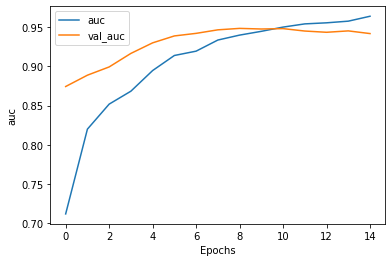

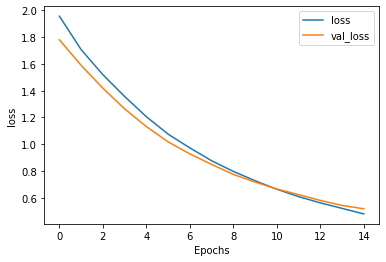

In [10]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "auc")  
plot_graphs(history, "loss")

In [11]:
model.load_weights(model_save_path)
scores_RNN = model.evaluate(val_dataset)

31/31 [==============================] - 0s 13ms/step - loss: 0.5167 - auc: 0.9418


### LSTM

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, kernel_regularizer=wd)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer=wd)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=wd),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         905984    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
%%time
num_epochs = 15
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.AUC()]
             )

model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      save_best_only=True,
                                      verbose=1
                                     )

history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset,
    callbacks=[checkpoint_callback])

Epoch 1/15
123/124 [============================>.] - ETA: 0s - loss: 6.1904 - auc_1: 0.5359
Epoch 00001: val_loss improved from inf to 5.33512, saving model to best_model.h5
124/124 [==============================] - 6s 44ms/step - loss: 6.1874 - auc_1: 0.5363 - val_loss: 5.3351 - val_auc_1: 0.8605
Epoch 2/15
123/124 [============================>.] - ETA: 0s - loss: 4.7433 - auc_1: 0.6698
Epoch 00002: val_loss improved from 5.33512 to 4.13859, saving model to best_model.h5
124/124 [==============================] - 4s 36ms/step - loss: 4.7417 - auc_1: 0.6695 - val_loss: 4.1386 - val_auc_1: 0.8703
Epoch 3/15
123/124 [============================>.] - ETA: 0s - loss: 3.6831 - auc_1: 0.7681
Epoch 00003: val_loss improved from 4.13859 to 3.20296, saving model to best_model.h5
124/124 [==============================] - 5s 37ms/step - loss: 3.6815 - auc_1: 0.7683 - val_loss: 3.2030 - val_auc_1: 0.8837
Epoch 4/15
123/124 [============================>.] - ETA: 0s - loss: 2.8565 - auc_1: 0.8

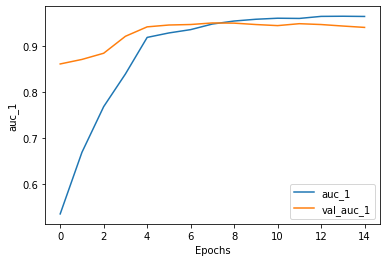

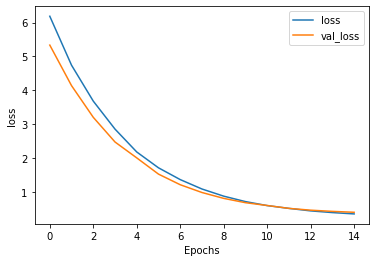

In [14]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "auc_1")  
plot_graphs(history, "loss")

In [15]:
model.load_weights(model_save_path)
scores_LSTM = model.evaluate(val_dataset)

31/31 [==============================] - 0s 12ms/step - loss: 0.3991 - auc_1: 0.9396


### GRU

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(64, return_sequences=True, kernel_regularizer=wd),
    tf.keras.layers.GRU(32, kernel_regularizer=wd),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=wd),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         905984    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
gru (GRU)                    (None, None, 64)          37248     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [17]:
%%time
num_epochs = 15
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.AUC()]
             )

model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      save_best_only=True,
                                      verbose=1
                                     )

history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset,
    callbacks=[checkpoint_callback])

Epoch 1/15
124/124 [==============================] - ETA: 0s - loss: 2.9140 - auc_2: 0.6193
Epoch 00001: val_loss improved from inf to 2.48873, saving model to best_model.h5
124/124 [==============================] - 3s 28ms/step - loss: 2.9140 - auc_2: 0.6193 - val_loss: 2.4887 - val_auc_2: 0.8714
Epoch 2/15
124/124 [==============================] - ETA: 0s - loss: 2.2706 - auc_2: 0.7961
Epoch 00002: val_loss improved from 2.48873 to 2.02355, saving model to best_model.h5
124/124 [==============================] - 3s 24ms/step - loss: 2.2706 - auc_2: 0.7961 - val_loss: 2.0235 - val_auc_2: 0.8840
Epoch 3/15
124/124 [==============================] - ETA: 0s - loss: 1.8566 - auc_2: 0.8383
Epoch 00003: val_loss improved from 2.02355 to 1.66334, saving model to best_model.h5
124/124 [==============================] - 3s 24ms/step - loss: 1.8566 - auc_2: 0.8383 - val_loss: 1.6633 - val_auc_2: 0.8941
Epoch 4/15
124/124 [==============================] - ETA: 0s - loss: 1.5293 - auc_2: 0.8

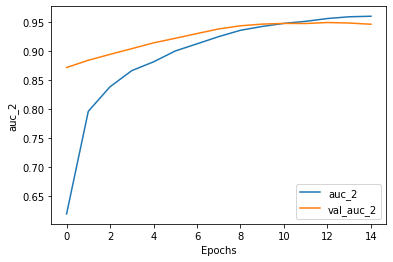

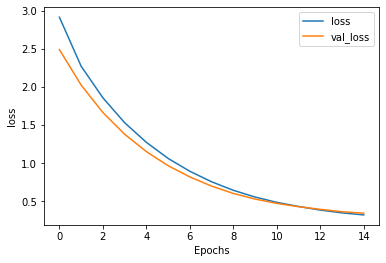

In [18]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "auc_2")  
plot_graphs(history, "loss")

In [19]:
model.load_weights(model_save_path)
scores_GRU = model.evaluate(val_dataset)

31/31 [==============================] - 0s 7ms/step - loss: 0.3424 - auc_2: 0.9460


Для сравнения результатов работы трех сетей использовались одинаковые классификаторы. Также одинаковое количество рекуррентных слоев и одинаковое количество ячеек в слоях.

In [20]:
scores_RNN

[0.5167257785797119, 0.9418167471885681]

In [21]:
scores_LSTM

[0.3991452753543854, 0.9395708441734314]

In [22]:
scores_GRU

[0.34241074323654175, 0.9459704756736755]

Все три сети быстро переобучились, лучшее качество показала сеть GRU.